# Next Character Prediction

This notebook contains the implementation of the next character prediction multi layer preceptron (MLP) model from Anrej Karparty's makemore series. 

Ref:
1. [Jupyter Notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)
2. [makemore](https://github.com/karpathy/makemore)
3. [Benjio's Paper: A Neural Probabilistic Language model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [3]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [7]:
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

## Helpers

In [8]:
# build vocabulary of character mapping to and from integers
chars = sorted(set(("".join(words))))
stoi = {c:i+1 for i,c in enumerate(chars)}
stoi['.'] = 0 #add character . to top of map
itos = {i:c for c,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Build Dataset

Inspired by Benjio's paper the model uses three character tokens to predict the next token

In [9]:
# build dataset

def build_dataset(words):
    block_size = 3 # contxt length
    X, Y = [], []
    for w in words:#[:5]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]),"--->",itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y


import random
random.seed(42)
random.shuffle(words)

# train, val/dev/ test split
# 80% , 10%, 10%
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [10]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

## Model

The model is a multi layer perceptron neural network, which is inspired from Benjio's paper. 

It consists of 3 layers
1. Embedding layer
2. Hidden Layer
3. Output Layer

![MLP Architecture](mlp_arch.png)

Embedding layer

In [6]:
# The embedding layer Look up table
emb_dim = 2 # dimension of each character embedding
# Lookup table
C = torch.randn((27,emb_dim)) # 26 alphabets + 1 ('.') character 
# input embedding
emb = C[X]

emb.shape

torch.Size([32, 3, 2])

Hidden Layer

In [7]:
W1 = torch.randn((6, 100)) # 3*2 (3 characters of 2 dimension each)
b1 = torch.randn(100)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

# b1 broadcasting check
# emb@W1 : 32  100
# b1     :  1  100

h.shape

torch.Size([32, 100])

Output Layer

In [8]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [9]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
loss = -probs[torch.arange(32),Y].log().mean() # negative log likelihood of probabilities
loss

tensor(17.8391)

In [ ]:
# use cross_entrophy function to do the above steps from logits efficiently
# cross entropy not only optimizes the computation memory but also makes it numerically stable.
# when logits is returning big positive number counts becomes extremly large number (inf)
# inorder to deal with this, this function subtracts all logits with max(logits)  
f.cross_entropy(logits, Y)

tensor(17.8391)

### Full Network model: Emb_dim = 2

In [ ]:
# # forward pass
# def forward(X,C,W1,b1,W2,b2):
#     # input embedding
#     emb = C[X]
#     h = torch.tanh(emb.view(-1,6) @ W1 + b1)
#     logits = h @ W2 + b2
#     return logits

In [221]:
# Network initializations
emb_dim = 2 # dimension of each character embedding
context_len = 3 # number or input characters / context lenghts
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,emb_dim), generator=g) # 26 alphabets + 1 ('.') character 
W1 = torch.randn((emb_dim*context_len, 300), generator=g) # 3*2 (3 characters of 2 dimension each)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [222]:
sum(p.nelement() for p in parameters) # total number of parameters

10281

In [223]:
for p in parameters:
    p.requires_grad = True

In [224]:
# Tuning Learning rate lr
# lower bound : 1e-3, upper bound: 1
lre = torch.linspace(-3, 0, 1000) # learning rate exponents
lrs = 10**lre

In [225]:
EPOCHS = 30_000     # number of training iterations
BATCH_SIZE = 32 # mini-batch size

In [263]:
lrei = []
lossi =[]
stepi =[]

# training loop
for i in range(EPOCHS):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    
    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    loss = f.cross_entropy(logits,Ytr[ix])
    
    # backward pass
    for p in parameters: 
        p.grad = None # set zero-gradients
    loss.backward()

    # update
    lr = 0.001 #lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    # # track-stats
    # lrei.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())



# print(loss.item())


In [264]:
# Forward pass
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2    # (32, 27)
loss = f.cross_entropy(logits,Ytr)
loss.item()

2.188110589981079

In [265]:
# Plot learning rates
# plt.plot(lrei, lossi)
# plt.plot(stepi, lossi)

In [ ]:
# Forward pass
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2    # (32, 27)
loss = f.cross_entropy(logits,Ydev)
loss.item()

2.203530788421631

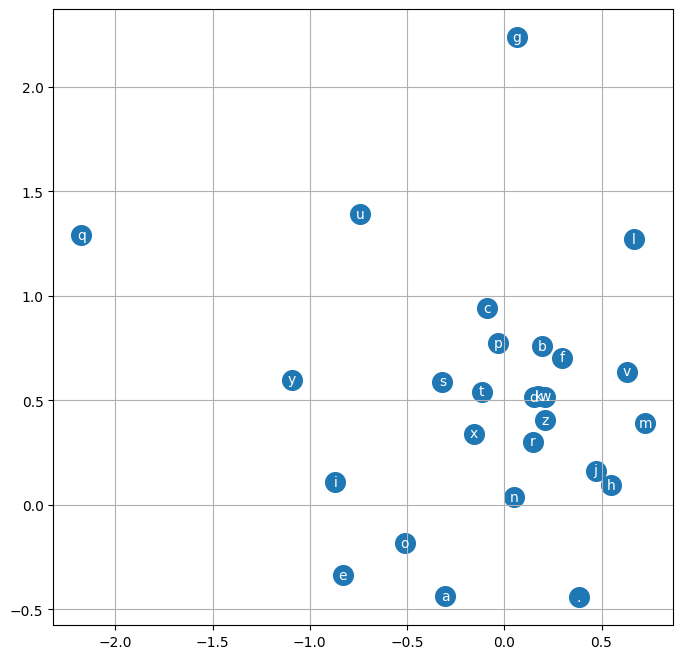

In [267]:
from turtle import color


plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va='center', color='white')
plt.grid('minor')

### Full Network Model: Emb_dim=10

In [371]:
# Network initializations
emb_dim = 10 # dimension of each character embedding
context_len = 3 # number or input characters / context lenghts
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,emb_dim), generator=g) # 26 alphabets + 1 ('.') character 
W1 = torch.randn((emb_dim*context_len, 300), generator=g) # 3*2 (3 characters of 2 dimension each)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [372]:
sum(p.nelement() for p in parameters) # total number of parameters

17697

In [373]:
for p in parameters:
    p.requires_grad = True

In [374]:
# # Tuning Learning rate lr
# # lower bound : 1e-3, upper bound: 1
# lre = torch.linspace(-3, 0, 1000) # learning rate exponents
# lrs = 10**lre

In [375]:
EPOCHS = 200_000     # number of training iterations
BATCH_SIZE = 32 # mini-batch size

In [376]:
lrei = []
lossi =[]
stepi =[]

# training loop
for i in range(EPOCHS):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    
    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    loss = f.cross_entropy(logits,Ytr[ix])
    
    # backward pass
    for p in parameters: 
        p.grad = None # set zero-gradients
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 if i < 150_000 else 0.001#lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    # # track-stats
    # lrei.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())



# print(loss.item())


In [377]:
# plt.plot(stepi,lossi)

In [378]:
# Forward pass
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2    # (32, 27)
loss = f.cross_entropy(logits,Ytr)
loss.item()

2.1012520790100098

In [379]:
# Forward pass
emb = C[Xdev]  # (32, 3, 2)
h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2    # (32, 27)
loss = f.cross_entropy(logits,Ydev)
loss.item()

2.1674981117248535

## Sample from model

In [324]:
# sample from the network model
with torch.no_grad():
    g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(20):
        out = []
        context = [0] * context_len # initialize with all ...
        while True:
            # forward pass
            emb = C[torch.tensor([context])] # 1, 3, 10
            h = torch.tanh(emb.view(-1, emb_dim*context_len)@W1 + b1)
            logits = h@W2 + b2
            probs = f.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(ix)
            context = context[1:] + [ix]

            if ix == 0:
                break


        print("".join(itos[i] for i in out))

carmah.
amelle.
khy.
mili.
tatyah.
cassie.
rahnen.
delynn.
jareei.
ner.
kia.
chaiivia.
leigh.
ham.
join.
quinton.
lilea.
jadii.
wazell.
dearyn.


## E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2 

In [383]:

def train_model(emb_dim, context_len, nhidden, batch_size):
    # Network initializations
    emb_dim = 10 # dimension of each character embedding
    context_len = 3 # number or input characters / context lenghts
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn((27,emb_dim), generator=g) # 26 alphabets + 1 ('.') character 
    W1 = torch.randn((emb_dim*context_len, nhidden), generator=g) # 3*2 (3 characters of 2 dimension each)
    b1 = torch.randn(nhidden, generator=g)
    W2 = torch.randn((nhidden,27), generator=g)
    b2 = torch.randn(27, generator=g)
    parameters = [C, W1, b1, W2, b2]

    print("Number of parameters: ", sum(p.nelement() for p in parameters))

    for p in parameters:
        p.requires_grad = True


    def forward_pass(X, Y):
        # Forward pass
        emb = C[X]  # (32, 3, 2)
        h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
        logits = h @ W2 + b2    # (32, 27)
        loss = f.cross_entropy(logits,Y)
        return loss

    EPOCHS = 200_000     # number of training iterations
    BATCH_SIZE = batch_size # mini-batch size


    lrei = []
    lossi =[]
    stepi =[]

    # training loop
    for i in range(EPOCHS):
        # mini-batch
        ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
        
        # Forward pass
        loss = forward_pass(Xtr[ix], Ytr[ix])

        # backward pass
        for p in parameters: 
            p.grad = None # set zero-gradients
        loss.backward()

        # update
        lr = 0.1 if i < 100_000 else 0.01 if i < 150_000 else 0.001#lrs[i]
        for p in parameters:
            p.data += -lr*p.grad

        # # track-stats
        # lrei.append(lre[i])
        stepi.append(i)
        lossi.append(loss.log10().item())

    with torch.no_grad():
        # Train loss
        tr_loss = forward_pass(Xtr, Ytr).item()
        print(f"{tr_loss=}")

        # Dev loss
        dev_loss = forward_pass(Xdev, Ydev).item()
        print(f"{dev_loss=}")

    
    return tr_loss, dev_loss


Hyper parameter Tuning:

In [384]:
# hyper paramters
emb_dim = [10, 27, 50]
context_len = [3, 4, 5]
hidden_layers = [300, 400, 500, 1000]
batch_sizes = [8, 16, 32, 64, 128]
# ephocs = [200_000, 300_000]

results = []
best_loss = torch.inf
best_setting = {}

for e in emb_dim:
    for c in context_len:
        for h in hidden_layers:
            for b in batch_sizes:
                print(f"Training model with {e=} {c=} {h=} {b=}")
                tr_loss, dev_loss= train_model(e, c, h, b)
                results.append({
                    'Embedding Dim': e,
                    'Context len' : c,
                    'Hidden layer': h,
                    "Batch Size":b,
                    "Train loss": tr_loss,
                    "Dev Loss": dev_loss
                })

                if dev_loss < best_loss:
                    print("Best Loss found:", dev_loss)
                    best_loss = dev_loss
                    best_setting = {
                    'Embedding Dim': e,
                    'Context len' : c,
                    'Hidden layer': h,
                    "Batch Size":b,
                    "Train loss": tr_loss,
                    "Dev Loss": dev_loss
                }
                print("="*100)




Training model with e=10 c=3 h=300 b=8
Number of parameters:  17697
tr_loss=2.1629085540771484
dev_loss=2.202441453933716
Best Loss found: 2.202441453933716
Training model with e=10 c=3 h=300 b=16
Number of parameters:  17697
tr_loss=2.1554336547851562
dev_loss=2.192016124725342
Best Loss found: 2.192016124725342
Training model with e=10 c=3 h=300 b=32
Number of parameters:  17697
tr_loss=2.093942642211914
dev_loss=2.1461846828460693
Best Loss found: 2.1461846828460693
Training model with e=10 c=3 h=300 b=64
Number of parameters:  17697
tr_loss=2.097217559814453
dev_loss=2.1570279598236084
Training model with e=10 c=3 h=300 b=128
Number of parameters:  17697
tr_loss=2.1088707447052
dev_loss=2.1613714694976807
Training model with e=10 c=3 h=400 b=8
Number of parameters:  23497
tr_loss=2.1462788581848145
dev_loss=2.198143482208252
Training model with e=10 c=3 h=400 b=16
Number of parameters:  23497
tr_loss=2.1166934967041016
dev_loss=2.1839492321014404
Training model with e=10 c=3 h=400 

In [385]:
best_setting

{'Embedding Dim': 10,
 'Context len': 3,
 'Hidden layer': 400,
 'Batch Size': 128,
 'Train loss': 2.0757360458374023,
 'Dev Loss': 2.137221336364746}

## E02: I was not careful with the intialization of the network in this video. 

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?
 
(2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [17]:
# Getting perdicted probabilities at initialization perfectly uniform 
# In other words, the model is expected to predict each character with equal probability.
# This is equivalent to the model predicting the logits as 0 for all characters.
# The loss in this case is -log(1/27) for each character.
-torch.tensor(1/27).log().item()

3.295836925506592

Initialize weights and biases of network to obtain the nll loss similar to `3.29`

In [53]:
# Network initializations
emb_dim = 10 # dimension of each character embedding
context_len = 3 # number or input characters / context lenghts
nhidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,emb_dim),                   generator=g) # 26 alphabets + 1 ('.') character 
W1 = torch.randn((emb_dim*context_len, nhidden),generator=g) * 0.01
b1 = torch.randn(nhidden,                       generator=g) * 0.01
W2 = torch.randn((nhidden,27),                  generator=g) * 0.01
b2 = torch.randn(27,                            generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Number of parameters: ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


def forward_pass(X, Y):
    # Forward pass
    emb = C[X]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    loss = f.cross_entropy(logits,Y)
    return loss

EPOCHS = 200_000     # number of training iterations
BATCH_SIZE = 32 # mini-batch size


lrei = []
lossi =[]
stepi =[]

# training loop
for i in range(EPOCHS):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    
    # Forward pass
    # loss = forward_pass(Xtr[ix], Ytr[ix])
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    loss = f.cross_entropy(logits,Ytr[ix])
    print(f"{loss.item()=}")

    # # backward pass
    # for p in parameters: 
    #     p.grad = None # set zero-gradients
    # loss.backward()

    # # update
    # lr = 0.1 if i < 100_000 else 0.01 if i < 150_000 else 0.001#lrs[i]
    # for p in parameters:
    #     p.data += -lr*p.grad

    # # # track-stats
    # # lrei.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.log10().item())
    break

Number of parameters:  11897
loss.item()=3.297171115875244


In [55]:
counts = logits.exp()
probs = counts/counts.sum(dim=1, keepdim=True)
probs[0] # probabilities of all characters for the first character in the batch

tensor([0.0368, 0.0377, 0.0369, 0.0372, 0.0372, 0.0369, 0.0369, 0.0371, 0.0371,
        0.0372, 0.0374, 0.0368, 0.0370, 0.0365, 0.0369, 0.0371, 0.0369, 0.0366,
        0.0365, 0.0370, 0.0373, 0.0375, 0.0374, 0.0368, 0.0366, 0.0374, 0.0373],
       grad_fn=<SelectBackward0>)

Initializing weights and biases with the Random numbers is not always a good approach. Because this makes the network think some characters are more likely than others. For our problem we know that all 27 characters are equally likely given the previous character at input, so it's better to initialize the network in such a way it starts at predicting equal probabilities for all characters.

# E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

## Connecting Word Features to Output
Paper claims the learning of "linear" part of mapping from word features to log-probabilities is faster

In [99]:
# Network initializations
emb_dim = 10 # dimension of each character embedding
context_len = 3 # number or input characters / context lenghts
nhidden = 200
nvocab = 27
direct = True
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((nvocab,emb_dim),                   generator=g) # 26 alphabets + 1 ('.') character 
W1 = torch.randn((emb_dim*context_len, nhidden),    generator=g) #* 0.01
b1 = torch.randn(nhidden,                           generator=g) #* 0.01
W2 = torch.randn((nhidden,nvocab),                  generator=g) #* 0.01
b2 = torch.randn(nvocab,                            generator=g) #* 0
Wf = torch.randn((emb_dim*context_len, nvocab),     generator=g) #* 0.01
bf = torch.randn(nvocab,                            generator=g) #* 0
parameters = [C, W1, b1, W2, b2]

print("Number of parameters: ", sum(p.nelement() for p in parameters))

if direct:
    parameters.append(Wf)
    parameters.append(bf)

for p in parameters:
    p.requires_grad = True


# def forward_pass(X, Y):
#     # Forward pass
#     emb = C[X]  # (32, 3, 2)
#     print(f"{emb.shape=}")
#     h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
#     print(f"{h.shape=}")
#     logits = h @ W2 + b2    # (32, 27)
#     loss = f.cross_entropy(logits,Y)
#     return logits, loss

EPOCHS = 50_000     # number of training iterations
BATCH_SIZE = 32 # mini-batch size


lrei = []
lossi =[]
stepi =[]

# training loop
for i in range(EPOCHS):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    
    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    if direct:
        logits += emb.view(-1, emb_dim*context_len)@Wf + bf    # (32, 27)
    loss = f.cross_entropy(logits,Ytr[ix])
    
    if i % (EPOCHS//10) == 0:
        print(f"{loss.item()=}")


    # backward pass
    for p in parameters: 
        p.grad = None # set zero-gradients


    loss.backward()

    # update
    lr = 0.1 if i < 30_000 else 0.01 if i < 40_000 else 0.001#lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    # # track-stats
    # lrei.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())



Number of parameters:  11897
loss.item()=26.46274757385254
loss.item()=2.10806941986084
loss.item()=2.6410505771636963
loss.item()=2.9132485389709473
loss.item()=2.111428737640381
loss.item()=2.2085177898406982
loss.item()=2.648627519607544
loss.item()=2.2578189373016357
loss.item()=2.3211097717285156
loss.item()=2.3930323123931885


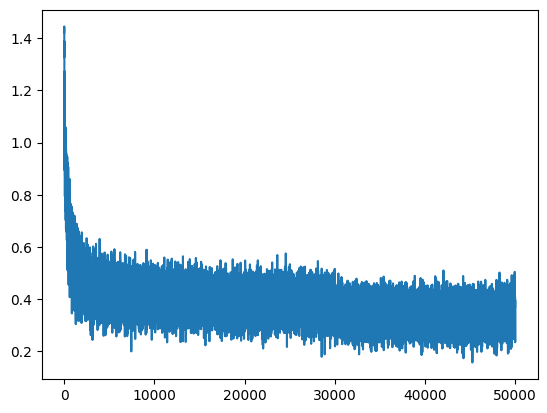

In [100]:
plt.plot(stepi,lossi)

There is no discernable impact on connecting word features to output. We can only see a very small improvement in the training loss over epochs. 

## Mix probability model

Add smoothened trigram model given in Section 4.1 in the paper. The following works have 2 differnt implementations

1. Assume $\alpha$ values with prior knowledge and weigh the decision of the trigram model and NN model equally $\lambda=0.5$. This approach is very close to paper, only difference being the $\alpha\text{'s}$ are estimated using Expectation Maxmimisation (EM) algorithm in the paper. [link](https://colab.research.google.com/drive/10ukMasBgdV3BeD7MIJKwQUtaCasNulZx?usp=sharing)
2. Learn the weights of the trigram model along with the NN model during training [link](https://github.com/sohammistri/makemore/blob/main/part-2-exercise/P3-probability-model-mixing.ipynb)


I'm going to implement the 1st approach

## Build N-grams model

In [155]:
# build ngrams
words_tr = words[:n1]
words_dev = words[n1:n2]
words_test = words[n2:]

print(f"{len(words_tr)=} {len(words_dev)=} {len(words_test)=}")

eps = 1e-3
count_unigrams = torch.zeros(27, dtype=torch.int32) + eps
count_bigrams = torch.zeros(27, 27, dtype=torch.int32) + eps
count_trigrams = torch.zeros(27, 27, 27, dtype=torch.int32) + eps

for _w in words_tr:
    w = ['.'] + list(_w) + ['.']
    for i, ch in enumerate(w):
        ix = stoi[ch]
        count_unigrams[ix] += 1
        if i < 1:
            continue
        count_bigrams[stoi[w[i-1]], ix] += 1
        if i < 2:
            continue
        count_trigrams[stoi[w[i-2]], stoi[w[i-1]], ix] += 1


prob_unigrams = count_unigrams/count_unigrams.sum()
prob_bigrams = count_bigrams/count_bigrams.sum(dim=1, keepdim=True)
prob_trigrams = count_trigrams/count_trigrams.sum(dim=2, keepdim=True)

len(words_tr)=25626 len(words_dev)=3203 len(words_test)=3204


In [156]:
# set alphas (interpolation weights)
alpha_3 = 0.7 # trigram weight
alpha_2 = 0.2 # bigram weight
alpha_1 = 0.1 # unigram weight

In [168]:
# smoothend trigram model
prob_trigrams_smoothend = alpha_1 * prob_unigrams + alpha_2 * prob_bigrams + alpha_3 * prob_trigrams

In [169]:
prob_trigrams_smoothend.shape

torch.Size([27, 27, 27])

In [194]:
# Network initializations
emb_dim = 10 # dimension of each character embedding
context_len = 3 # number or input characters / context lenghts
nhidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,emb_dim),                   generator=g) # 26 alphabets + 1 ('.') character 
W1 = torch.randn((emb_dim*context_len, nhidden),generator=g) * 0.01
b1 = torch.randn(nhidden,                       generator=g) * 0.01
W2 = torch.randn((nhidden,27),                  generator=g) * 0.01
b2 = torch.randn(27,                            generator=g) * 0
parameters = [C, W1, b1, W2, b2]

print("Number of parameters: ", sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

EPOCHS = 200_000     # number of training iterations
BATCH_SIZE = 32 # mini-batch size


lrei = []
lossi =[]
stepi =[]
alpha = 0.5

# training loop
for i in range(EPOCHS):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,), generator=g)
    
    # Forward pass
    # loss = forward_pass(Xtr[ix], Ytr[ix])
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    probs = f.softmax(logits, dim=1)

    # get prob distribution of last two characters in context inorder to predict next char
    trigram_probs = prob_trigrams_smoothend[Xtr[ix][:, -2], Xtr[ix][:, -1], :] 

    comb_prob = alpha*probs + (1-alpha)*trigram_probs
    
    # negative log likelihood loss
    loss = -comb_prob[torch.arange(BATCH_SIZE), Ytr[ix]].log().mean()
    # loss = f.cross_entropy(logits,Ytr[ix])
    if i % (EPOCHS//10) == 0:
        print(f"{loss.item()=}")

    # backward pass
    for p in parameters: 
        p.grad = None # set zero-gradients
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 if i < 150_000 else 0.001#lrs[i]
    for p in parameters:
        p.data += -lr*p.grad

    # # track-stats
    # lrei.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

Number of parameters:  11897
loss.item()=2.3948566913604736
loss.item()=2.3601903915405273
loss.item()=1.9544622898101807
loss.item()=2.470388889312744
loss.item()=2.2870399951934814
loss.item()=1.9577383995056152
loss.item()=1.96755051612854
loss.item()=2.362408399581909
loss.item()=1.9106603860855103
loss.item()=2.0390048027038574


In [196]:
with torch.no_grad():
    # Train loss
    # Forward pass
    emb = C[Xtr]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    probs = f.softmax(logits, dim=1)
    # get prob distribution of last two characters in context inorder to predict next char
    trigram_probs = prob_trigrams_smoothend[Xtr[:, -2], Xtr[:, -1], :] 
    comb_prob = alpha*probs + (1-alpha)*trigram_probs
    tr_loss = -comb_prob[torch.arange(len(Xtr)), Ytr].log().mean()# negative log likelihood loss
    print(f"{tr_loss=}")

tr_loss=tensor(2.1147)


In [197]:
with torch.no_grad():
    # Dev loss
    # Forward pass
    emb = C[Xdev]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1,emb_dim*context_len) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2    # (32, 27)
    probs = f.softmax(logits, dim=1)
    # get prob distribution of last two characters in context inorder to predict next char
    trigram_probs = prob_trigrams_smoothend[Xdev[:, -2], Xdev[:, -1], :] 
    comb_prob = alpha*probs + (1-alpha)*trigram_probs
    dev_loss = -comb_prob[torch.arange(len(Xdev)), Ydev].log().mean()# negative log likelihood loss
    print(f"{dev_loss=}")

dev_loss=tensor(2.1487)


## Sample from model

In [198]:
# sample from the network model
with torch.no_grad():
    g = torch.Generator().manual_seed(2147483647 + 10)

    for _ in range(20):
        out = []
        context = [0] * context_len # initialize with all ...
        while True:
            # forward pass
            emb = C[torch.tensor([context])] # 1, 3, 10
            h = torch.tanh(emb.view(-1, emb_dim*context_len)@W1 + b1)
            logits = h@W2 + b2
            probs = f.softmax(logits, dim=1)
            # get prob distribution of last two characters in context inorder to predict next char
            trigram_probs = prob_trigrams_smoothend[context[-2], context[-1], :] 
            comb_prob = alpha*probs + (1-alpha)*trigram_probs
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            out.append(ix)
            context = context[1:] + [ix]

            if ix == 0:
                break


        print("".join(itos[i] for i in out))

carman.
amelilli.
kimleige.
tyrenley.
kenrah.
bradhery.
charqeig.
ramari.
chaily.
kaleig.
daymondi.
desian.
sulie.
alvin.
aura.
elo.
dearistin.
jenni.
sabella.
cora.
